# Imports

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqldf
import plotly.express as px
from tqdm import tqdm


from pyod.models.ecod import ECOD
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF

from sklearn.metrics import confusion_matrix
import numpy as np

# Read data

In [2]:
train_df = pd.read_csv("data/train.csv")

In [3]:
train_df.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


# First plots

In [4]:
len(train_df)

219129

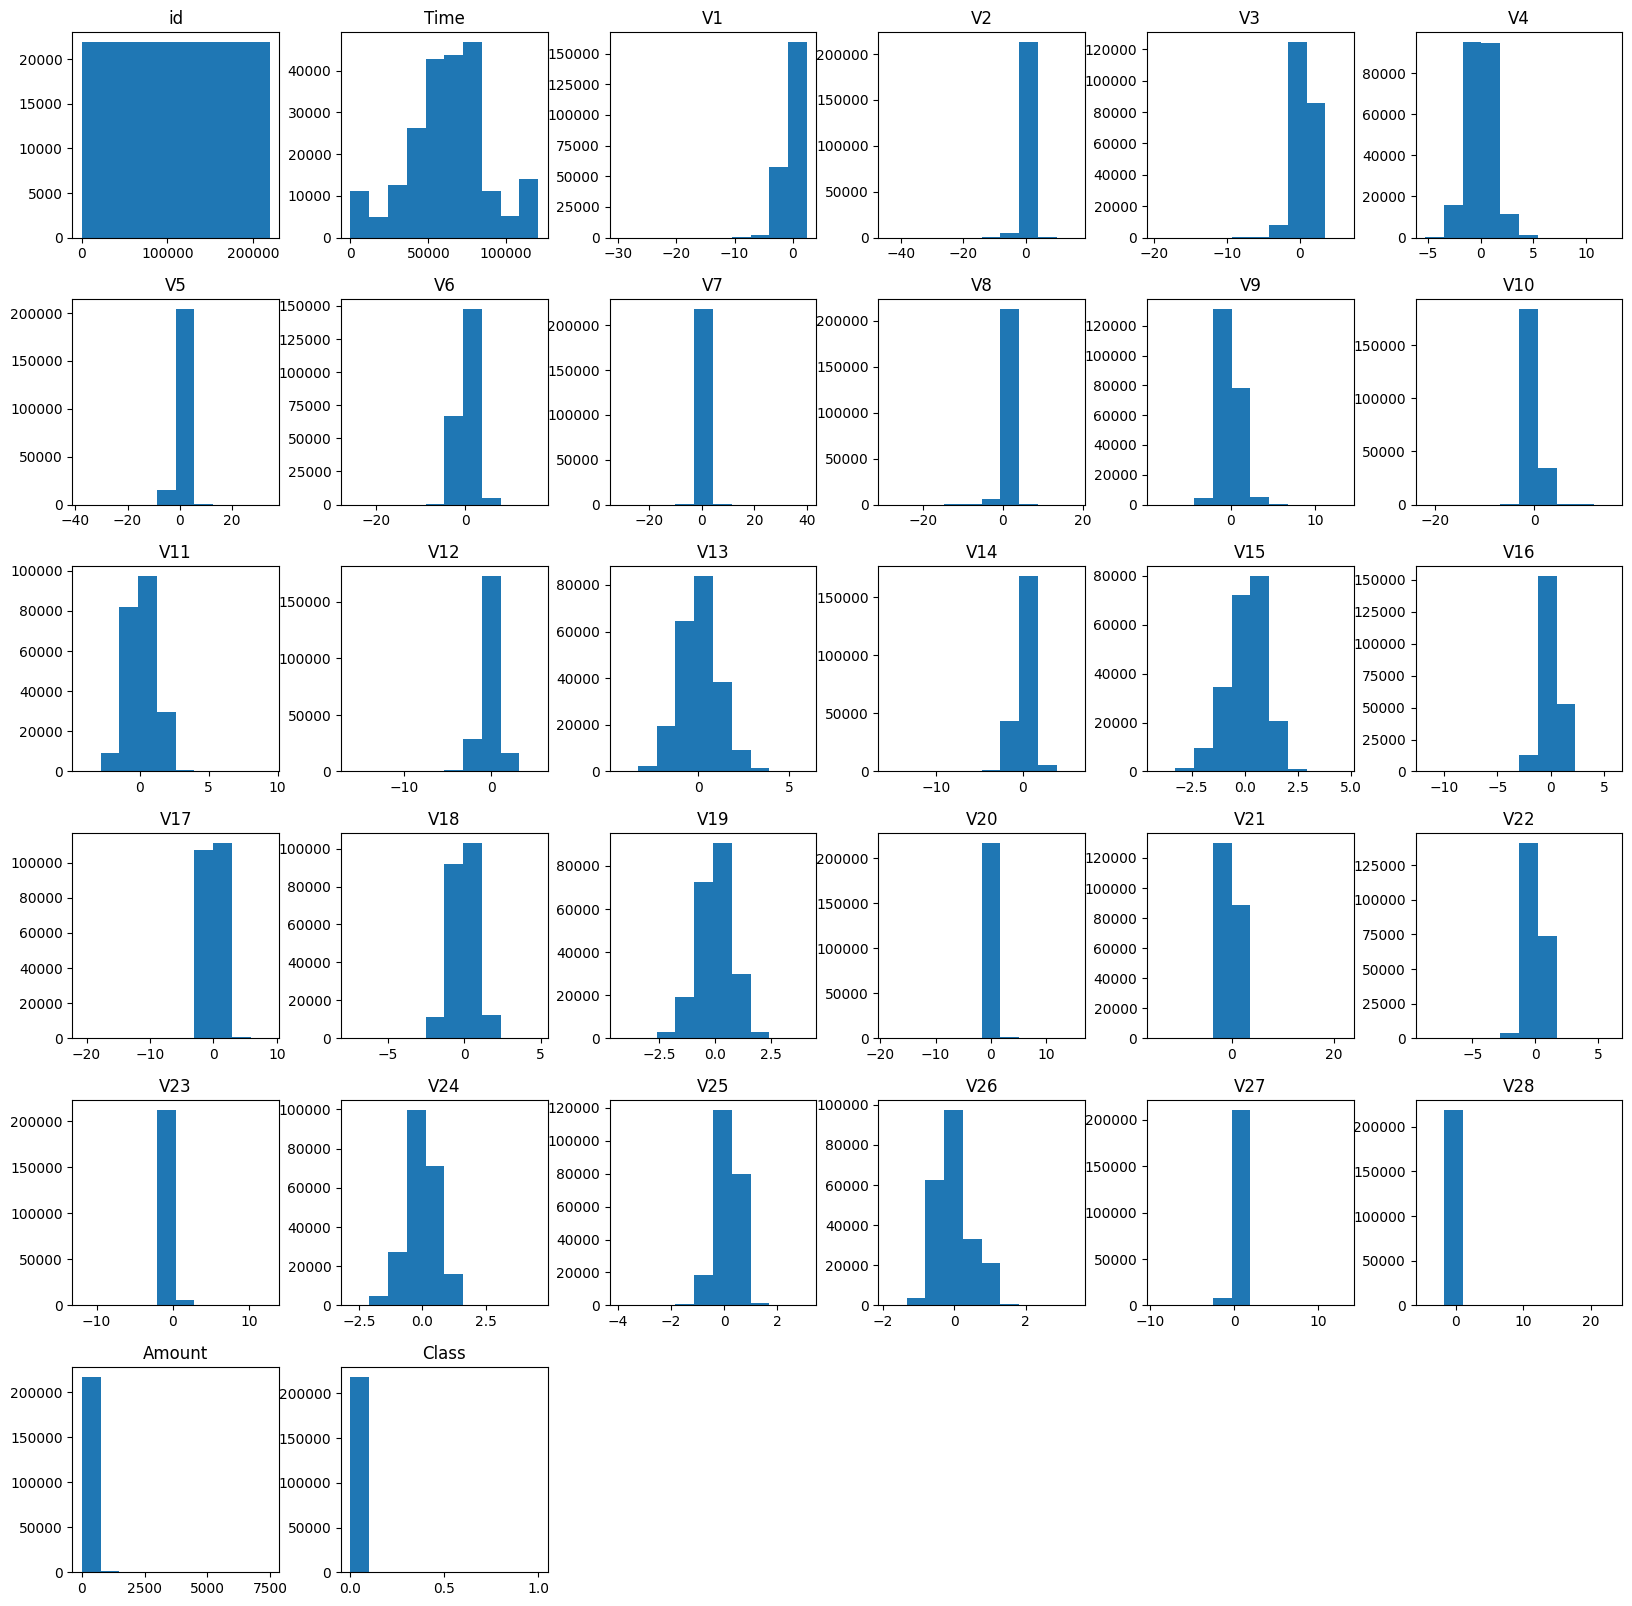

In [5]:
train_df.hist(figsize=(20,20), grid=False);

# Looking at outliers/fraud cases

**How many fraud cases are there in the train dataset?**

In [6]:
len(sqldf.run("select * from train_df where class = 1"))

469

**How high is the percentage of fraud cases out of all transactions?**

In [7]:
print(len(sqldf.run("select * from train_df where class = 1"))/len(train_df) * 100, "%")

0.214029179159308 %


In [10]:
train_df_normal = sqldf.run("select * from train_df where class = 0")
train_df_fraud = sqldf.run("select * from train_df where class = 1")

30it [01:16,  2.56s/it]


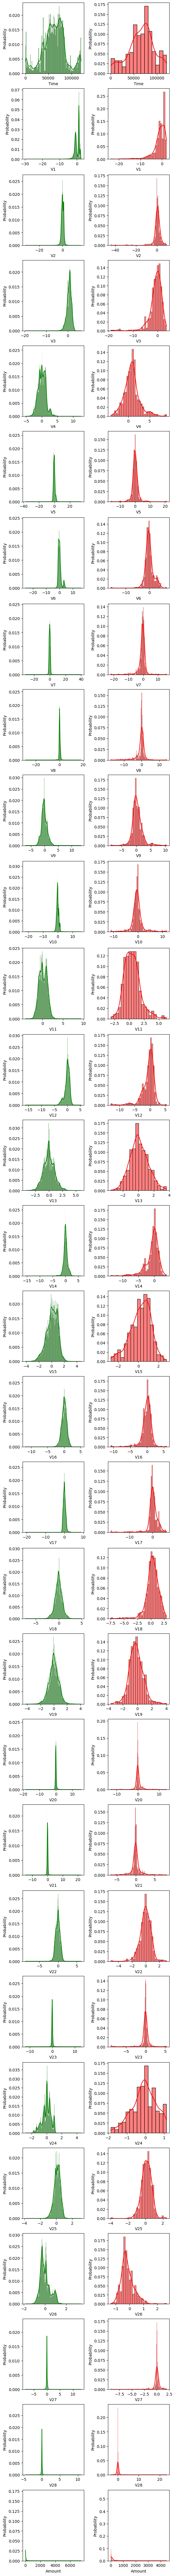

In [20]:
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

fig, axes = plt.subplots(len(features[:]), 2, figsize=(6,len(features[:])*3), layout='constrained')

for index, feature in tqdm(enumerate(features[:])):
    sns.histplot(data=train_df_normal, x=feature, ax=axes[index][0], color='green', label='normal', stat="probability", kde=True)
    sns.histplot(data=train_df_fraud, x=feature, ax=axes[index][1], color='red', label='fraud', stat="probability", kde=True)

28it [01:25,  3.04s/it]


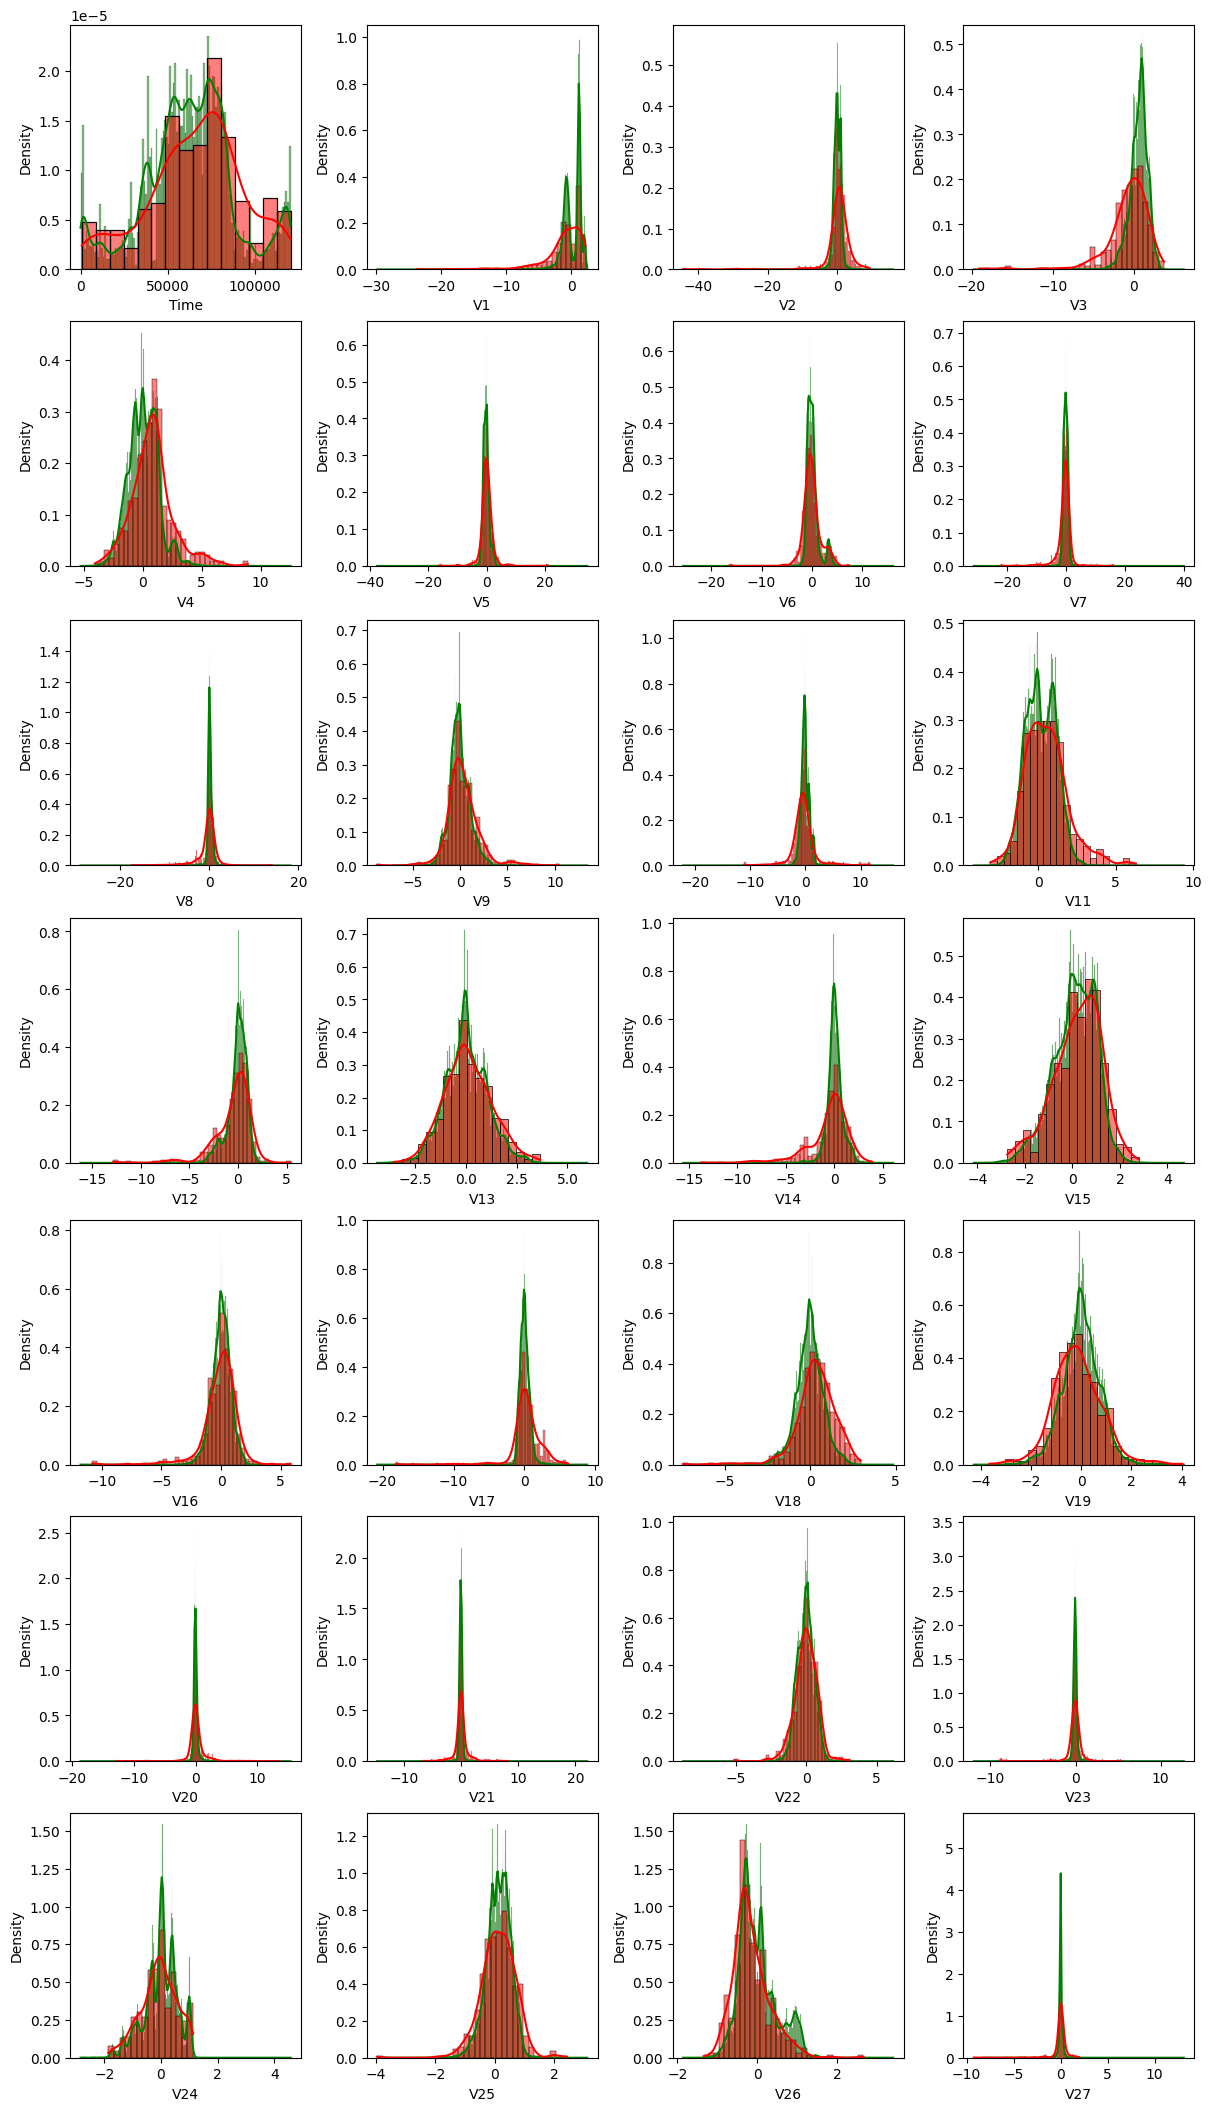

In [22]:
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

fig, axes = plt.subplots(len(features[:])//4, 4, figsize=(4*3,len(features[:])//4*3), layout='constrained')

for feature, ax in tqdm(zip(features[:], axes.flat)):
    sns.histplot(data=train_df_normal, x=feature, ax=ax, color='green', label='normal', stat="density", kde=True)
    sns.histplot(data=train_df_fraud, x=feature, ax=ax, color='red', label='fraud', stat="density", kde=True)

**What does an outlier look like?**

In [35]:
for index, outlier in train_df_fraud.iloc[:2].iterrows():
    print(outlier['V1'])

0.845796938377736
-1.80808941983399


30it [01:25,  2.87s/it]
30it [01:23,  2.78s/it]


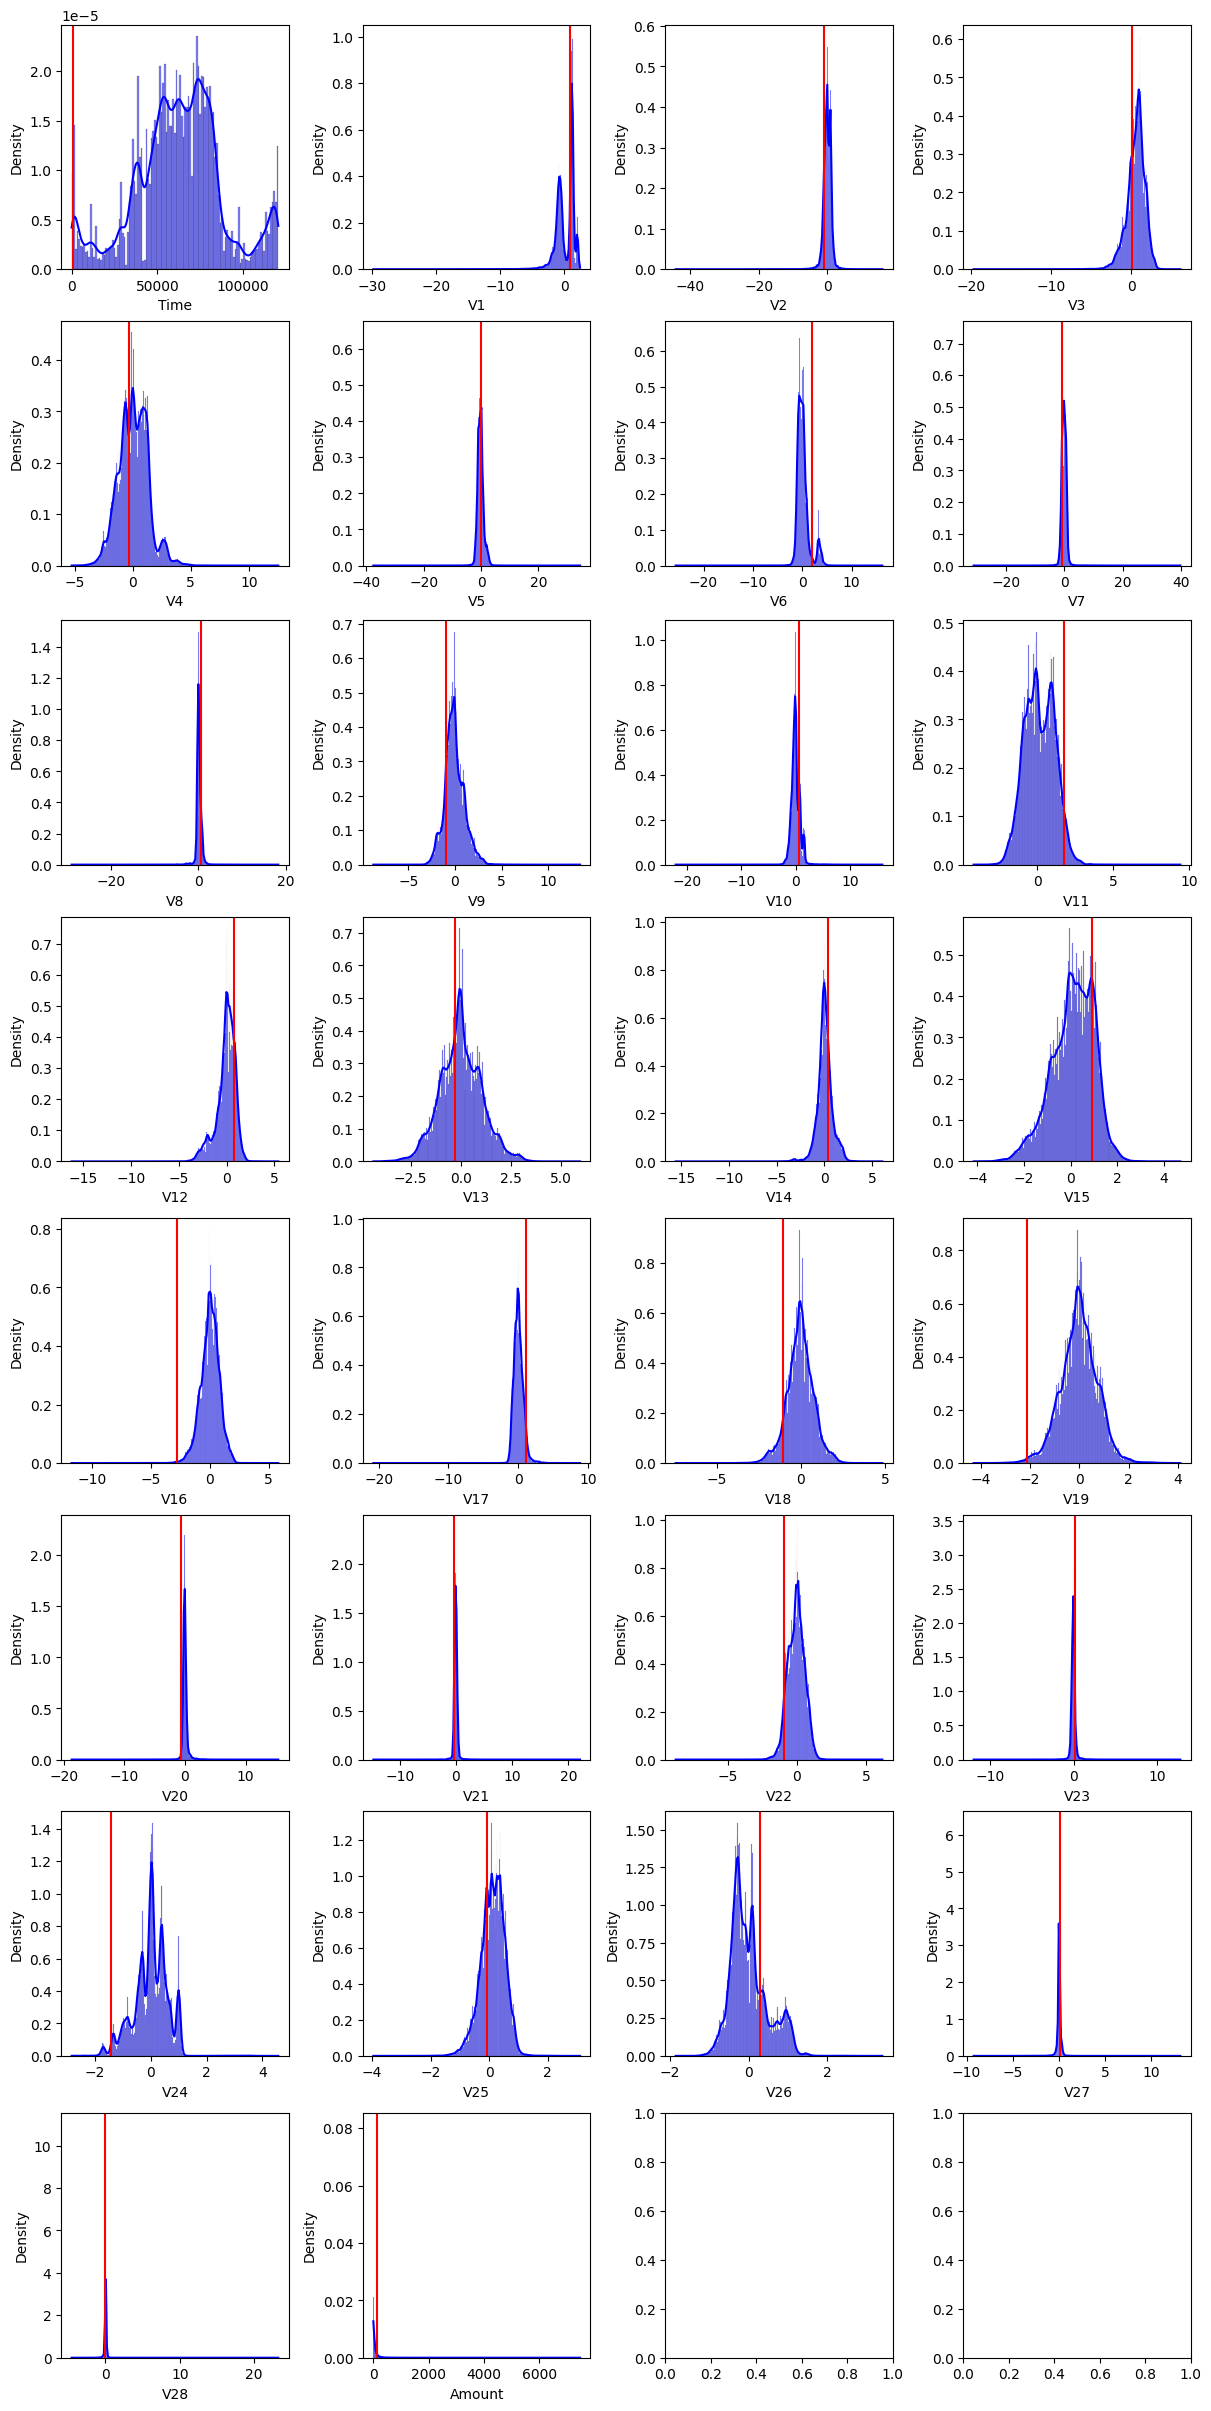

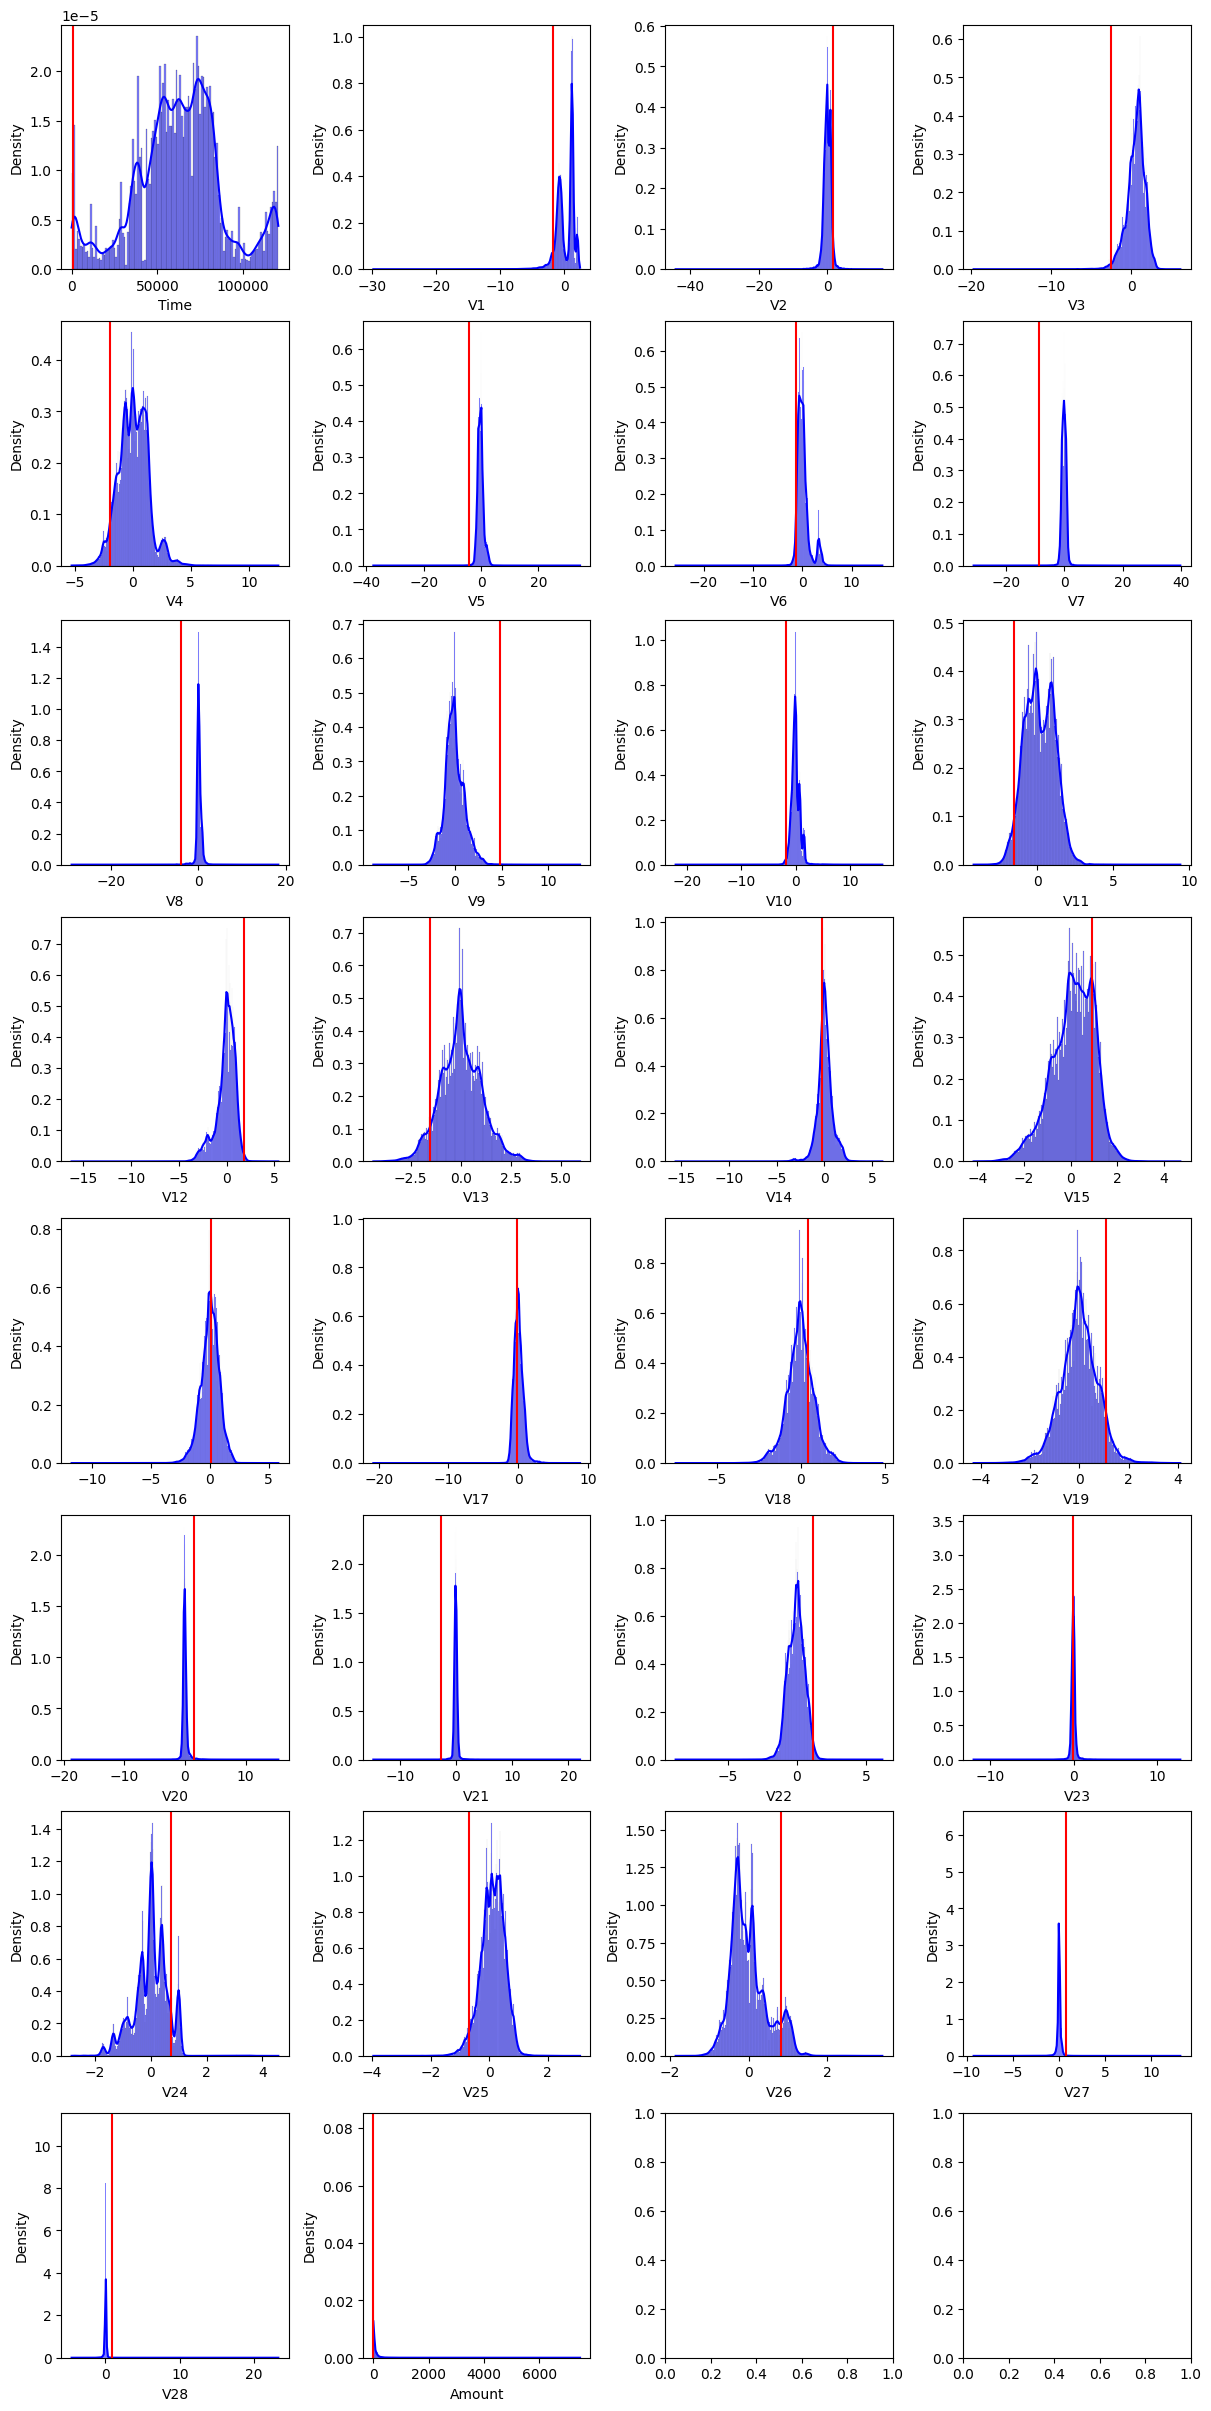

In [40]:
for index, outlier in train_df_fraud.iloc[:2].iterrows():
       features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
              'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
              'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

       fig, axes = plt.subplots(len(features[:])//4 + 1, 4, figsize=(4*3,(len(features[:])//4 + 1)*3), layout='constrained')

       for feature, ax in tqdm(zip(features[:], axes.flat)):
              sns.histplot(data=train_df, x=feature, ax=ax, color='blue', stat="density", kde=True)
              ax.axvline(x=outlier[feature], c='r')
       
       fig.savefig(fname=f"plots/outlier_{index}.png")

# Splitting the dataset

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df.columns

Index(['id', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [62]:
# converting to numpy
X_train_full = train_df.drop(['id', 'Class', 'Time'], axis=1).to_numpy()
y_train_full = train_df['Class'].to_numpy()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.33)

# First pyOD modeling try

In [76]:
model = ECOD(contamination=0.002)
model.fit(X_train)

# get outlier scores
y_train_scores = model.decision_scores_  # raw outlier scores on the train data
y_test_scores = model.decision_function(X_test)  # predict raw outlier scores on test

# accuracy on train set
print('train accuracy', sum(model.labels_ == y_train) / (len(y_train)))
# detection rate on on outliers
outlier_indices_train = np.argwhere(y_train == 1)
print('outlier detection rate', np.sum(model.labels_[outlier_indices_train] == y_train[outlier_indices_train]) / len(outlier_indices_train))

print('confusion matrix')
print(confusion_matrix(y_pred=model.labels_, y_true=y_train))

train accuracy 0.996206135571055
outlier detection rate 0.09034267912772585
confusion matrix
[[146230    265]
 [   292     29]]


## HBOS

In [70]:
model = HBOS(n_bins="auto", alpha=0.1, tol=0.2, contamination=0.003)
model.fit(X_train)

# get outlier scores
y_train_scores = model.decision_scores_  # raw outlier scores on the train data
#y_test_scores = model.decision_function(X_test)  # predict raw outlier scores on test

# accuracy on train set
print('train accuracy', sum(model.labels_ == y_train) / (len(y_train)))
# detection rate on on outliers
outlier_indices_train = np.argwhere(y_train == 1)
print('outlier detection rate', np.sum(model.labels_[outlier_indices_train] == y_train[outlier_indices_train]) / len(outlier_indices_train))

train accuracy 0.9952729947689625
outlier detection rate 0.1059190031152648


## Iforest

In [74]:
model = IForest(n_estimators=200, 
                max_samples='auto', 
                contamination=0.002, 
                max_features=0.8, 
                bootstrap=False, 
                n_jobs=1, 
                behaviour='old', random_state=None, verbose=0)
model.fit(X_train)

# get outlier scores
y_train_scores = model.decision_scores_  # raw outlier scores on the train data
y_test_scores = model.decision_function(X_test)  # predict raw outlier scores on test

# accuracy on train set
print('train accuracy', sum(model.labels_ == y_train) / (len(y_train)))
# detection rate on on outliers
outlier_indices_train = np.argwhere(y_train == 1)
print('outlier detection rate', np.sum(model.labels_[outlier_indices_train] == y_train[outlier_indices_train]) / len(outlier_indices_train))

train accuracy 0.9960426656495205
outlier detection rate 0.0529595015576324


## LOF

In [73]:
model = LOF(n_neighbors=20, 
            algorithm='auto', 
            leaf_size=30, 
            metric='minkowski', 
            p=2, 
            metric_params=None, 
            contamination=0.002, 
            n_jobs=1, 
            novelty=True)
model.fit(X_train)

# get outlier scores
y_train_scores = model.decision_scores_  # raw outlier scores on the train data
y_test_scores = model.decision_function(X_test)  # predict raw outlier scores on test

# accuracy on train set
print('train accuracy', sum(model.labels_ == y_train) / (len(y_train)))
# detection rate on on outliers
outlier_indices_train = np.argwhere(y_train == 1)
print('outlier detection rate', np.sum(model.labels_[outlier_indices_train] == y_train[outlier_indices_train]) / len(outlier_indices_train))

train accuracy 0.995879195727986
outlier detection rate 0.01557632398753894
